In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings("ignore")

# from yellowbrick.classifier import ClassPredictionError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [2]:
df = pd.read_csv('p2_dataset.csv')[['text', 'label']]
print(df.shape)
df = df.drop_duplicates()
df

(2131, 2)


,text,label
0,latest headlin cnn busi great shutdown newsroo...,0
4,china want take victori lap handl coronaviru o...,0
5,coronaviru disinform creat challeng china gove...,0
6,china coronaviru eat wild anim made illeg end ...,0
7,china economi could shrink first time decad co...,0
...,...,...
2126,mani countri around world success contain coro...,1
2127,need flatten curv coronaviru pandem encourag p...,1
2128,mysteri miss bu rider began bu driver small to...,1
2129,agn desert exemplar modernist literatur novel ...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 0 to 2130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2054 non-null   object
 1   label   2054 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.1+ KB


### Splitting the data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    stratify = df['label'],
                                                    test_size = 0.2,
                                                    random_state = 1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1643,) (411,) (1643,) (411,)


In [5]:
y_train.value_counts()

1    851
0    792
Name: label, dtype: int64

In [6]:
v = TfidfVectorizer()

X_train = v.fit_transform(X_train)
X_test = v.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1643, 24774) (411, 24774) (1643,) (411,)


In [7]:
X_train

<1643x24774 sparse matrix of type '<class 'numpy.float64'>'
	with 341109 stored elements in Compressed Sparse Row format>

### Model Training

In [8]:
# def visualizer(clf):
#     visualizer = ClassPredictionError(clf, classes= [0, 1])

#     # Fit the training data to the visualizer
#     visualizer.fit(X_train, y_train)

#     # Evaluate the model on the test data
#     visualizer.score(X_test, y_test)

#     # Draw visualization
#     visualizer.show()
    
def metrics(pred):
    classes = [0, 1]
    matrix = confusion_matrix(y_test, pred, labels = classes)
    mat = matrix.diagonal()/matrix.sum(axis=1)
    print(classification_report(y_test, pred, labels = classes,
                                digits=4))

    print('confusion matrix: ', mat)

    Accuracy = accuracy_score(y_test,pred)
    F1 = f1_score(y_test, pred, average='macro')
    print("Accuracy:", Accuracy)

    rec = recall_score(y_test, pred, average='macro')
    print('Recall: ', rec)
    prec = precision_score(y_test, pred, average='macro')
    print('Precision: ', prec)

    print('F1:', F1)
    
def get_predictions(tpr, fpr, threshold, ypred):
    #If tpr is hight & fpr is low : (tpr*(1-fpr)) is maximum
    actual_ypred = []

    thres = threshold[np.argmax(tpr * (1 - fpr))]
    for value in ypred:
        if value < thres:
            actual_ypred.append(0)
        else:
            actual_ypred.append(1)
    return actual_ypred
    
def get_roc_curve(model_name, classifier):
    
    Ypred_train = classifier.predict(X_train)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, Ypred_train)
    
    Ypred_test = classifier.predict(X_test)
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, Ypred_test)

    auc_train = round(auc(fpr_train, tpr_train), 4)
    auc_test = round(auc(fpr_test, tpr_test), 4)

    plt.rcParams["figure.figsize"] = [5, 4]
    plt.plot(fpr_train, tpr_train, label = f'train AUC : {auc_train}')
    plt.plot(fpr_test, tpr_test, label = f'test AUC : {auc_test}')
    plt.legend()
    plt.grid()
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('parameter') 
    plt.ylabel('AUC')
    plt.show()

    roc_results = {
    'ypred_train' : Ypred_train,
    'ypred_test' : Ypred_test,
    'fpr_train' : fpr_train,
    'fpr_test' : fpr_test,
    'tpr_train' : tpr_train,
    'tpr_test' : tpr_test,
    'threshold_train' : threshold_train,
    'threshold_test' : threshold_test
    }
    return roc_results

def get_confusion_matrix(model_name, roc_results):
    actual_ypred_train = get_predictions(roc_results['tpr_train'],
                                         roc_results['fpr_train'],
                                         roc_results['threshold_train'],
                                         roc_results['ypred_train'])

    matrix_train = confusion_matrix(y_train, actual_ypred_train)

    actual_ypred_test = get_predictions(roc_results['tpr_test'],
                                        roc_results['fpr_test'],
                                        roc_results['threshold_test'],
                                        roc_results['ypred_test'])

    matrix_test = confusion_matrix(y_test, actual_ypred_test)

    plt.rcParams["figure.figsize"] = [12, 5]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 2)
    
    axes[0].title.set_text(f'{model_name} Training Confusion Matrix')
    sns.heatmap(matrix_train, annot = True, ax = axes[0], fmt = "d")


    sns.heatmap(matrix_test, annot = True, ax = axes[1], fmt = "d")
    axes[1].title.set_text(f'{model_name} Testing Confusion Matrix')

    return actual_ypred_test, actual_ypred_train

### Random Forest Classifier

In [9]:
randomforest_model = RandomForestClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'max_samples' : [0.6, 0.8]
 }

cross_validation = 3
scoring_metric = "f1"
randomforest_model_cv = GridSearchCV(randomforest_model, 
                                     parameters,
                                     cv = cross_validation,
                                     scoring = scoring_metric,
                                     return_train_score=True)

randomforest_model_cv.fit(X_train, y_train)
print('Best Params ', randomforest_model_cv.best_params_)

Best Params  {'max_depth': 30, 'max_samples': 0.8, 'n_estimators': 150}


In [10]:
parameters = {
     'max_depth' : 30,
     'n_estimators' : 150,
     'max_samples' : 0.8
}
randomforest_model = RandomForestClassifier(max_depth = parameters['max_depth'],
                                            max_samples = parameters['max_samples'],
                                            n_estimators = parameters['n_estimators'])

randomforest_model.fit(X_train, y_train)
Ypredtest = randomforest_model.predict_proba(X_test)[:,1]

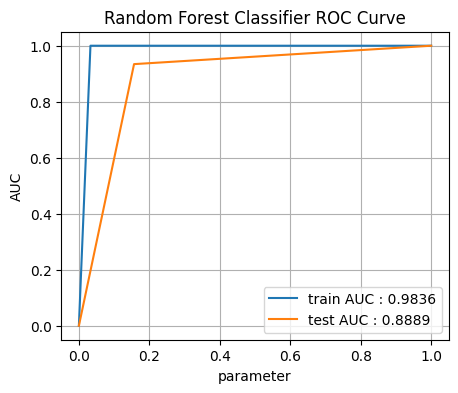

In [11]:
roc_results = get_roc_curve('Random Forest Classifier',
                             randomforest_model)

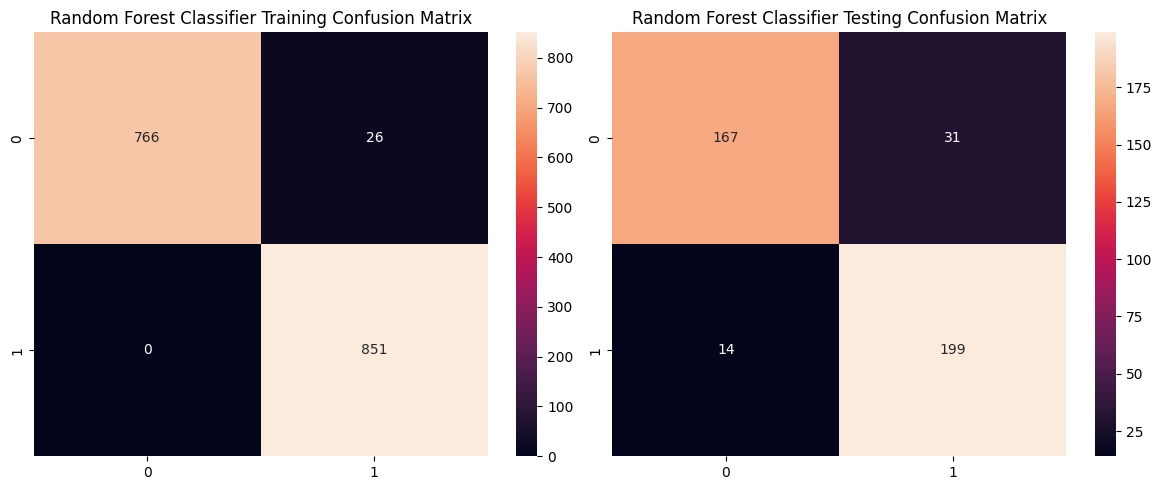

In [12]:
results = get_confusion_matrix('Random Forest Classifier',
                                roc_results)

In [13]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.9227    0.8434    0.8813       198
           1     0.8652    0.9343    0.8984       213

    accuracy                         0.8905       411
   macro avg     0.8939    0.8889    0.8898       411
weighted avg     0.8929    0.8905    0.8902       411

confusion matrix:  [0.84343434 0.9342723 ]
Accuracy: 0.8905109489051095
Recall:  0.8888533219519135
Precision:  0.8939346625030027
F1: 0.8898431776624953


### Logistic Regression

In [14]:
logistic_model = LogisticRegression()
parameters = { 'C' : [0.01, 0.1, 1, 3, 10],
               'penalty' : ['l2', 'elasticnet']
             }

cross_validation = 3
scoring_metric = "f1"

logistic_model_cv = GridSearchCV(logistic_model,
                                 parameters,
                                 cv = cross_validation,
                                 scoring = scoring_metric,
                                 return_train_score=True)

logistic_model_cv.fit(X_train, y_train)
print('Best Params ', logistic_model_cv.best_params_)

Best Params  {'C': 10, 'penalty': 'l2'}


In [15]:
parameters = { 'C' : 10,
               'penalty' : 'l2'
 }

logistic_model = LogisticRegression(C = parameters['C'], penalty = parameters['penalty'])
logistic_model.fit(X_train, y_train)
Ypredtest = logistic_model.predict_proba(X_test)[:,1]

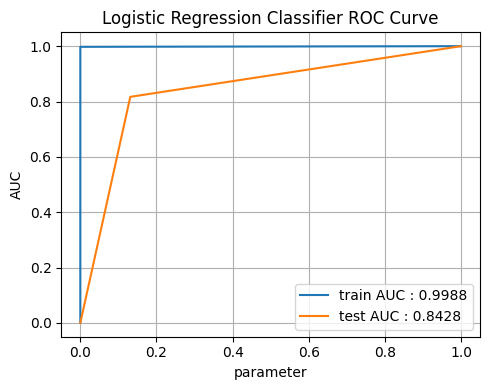

In [16]:
roc_results = get_roc_curve('Logistic Regression Classifier',
                             logistic_model)

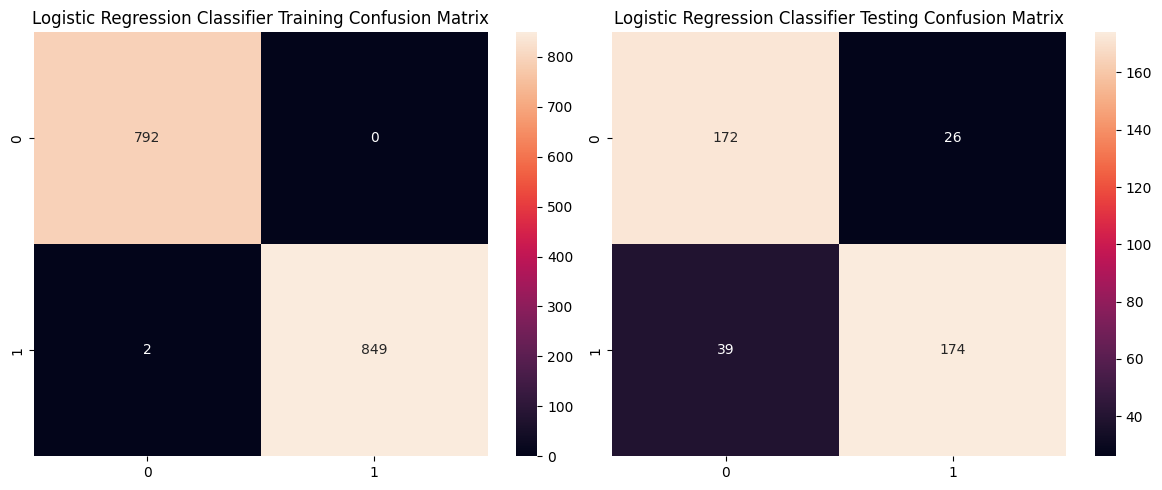

In [17]:
results = get_confusion_matrix('Logistic Regression Classifier',
                                roc_results)

In [18]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.8152    0.8687    0.8411       198
           1     0.8700    0.8169    0.8426       213

    accuracy                         0.8418       411
   macro avg     0.8426    0.8428    0.8418       411
weighted avg     0.8436    0.8418    0.8419       411

confusion matrix:  [0.86868687 0.81690141]
Accuracy: 0.8418491484184915
Recall:  0.8427941385687865
Precision:  0.8425829383886256
F1: 0.8418454033637822


### XG Boost

In [19]:
import xgboost

xgboost_model = xgboost.XGBClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'min_child_weight' : [1, 5, 10 ]
 }

cross_validation = 3
scoring_metric = "f1"
xgboost_model_cv = GridSearchCV(xgboost_model, 
                                parameters,
                                cv = cross_validation,
                                scoring = scoring_metric,
                                return_train_score=True)

xgboost_model_cv.fit(X_train, y_train)
print('Best Params ', xgboost_model_cv.best_params_)

Best Params  {'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 150}


In [20]:
parameters = { 'max_depth' : 30,
               'min_child_weight' : 1,
               'n_estimators' : 150
 }

xgboost_model = xgboost.XGBClassifier(max_depth = parameters['max_depth'],
                                      min_child_weight = parameters['min_child_weight'],
                                      n_estimators = parameters['n_estimators'])
xgboost_model.fit(X_train, y_train)
Ypredtest = xgboost_model.predict(X_test)

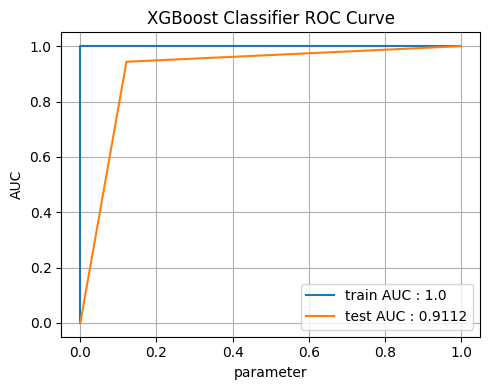

In [24]:
roc_results = get_roc_curve('XGBoost Classifier',
                             xgboost_model)

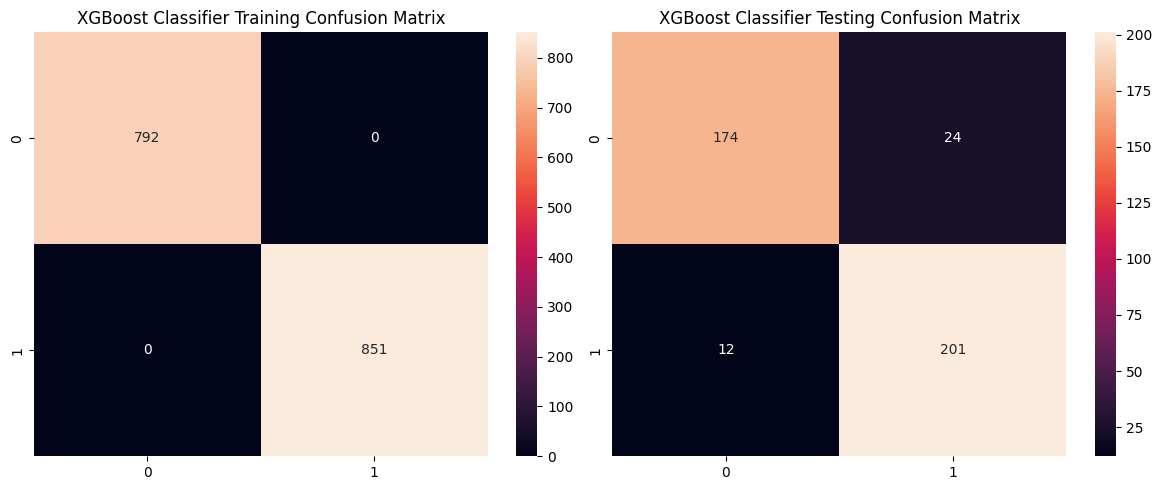

In [25]:
results = get_confusion_matrix('XGBoost Classifier',
                                roc_results)

In [26]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.9355    0.8788    0.9062       198
           1     0.8933    0.9437    0.9178       213

    accuracy                         0.9124       411
   macro avg     0.9144    0.9112    0.9120       411
weighted avg     0.9136    0.9124    0.9122       411

confusion matrix:  [0.87878788 0.94366197]
Accuracy: 0.9124087591240876
Recall:  0.9112249253094323
Precision:  0.9144086021505375
F1: 0.9120291095890412


### SVM

In [29]:
svm_model = SVC()

parameters = { 'kernel' : ['poly', 'rbf', 'sigmoid'],
               'max_iter' : [20, 50, 100]
 }

cross_validation = 3
scoring_metric = "f1"
svm_model_cv = GridSearchCV(svm_model, 
                            parameters,
                            cv = cross_validation,
                            scoring = scoring_metric,
                            return_train_score=True)

svm_model_cv.fit(X_train, y_train)
print('Best Params ', svm_model_cv.best_params_)

Best Params  {'kernel': 'rbf', 'max_iter': 100}


In [30]:
parameters = {
         'kernel' : 'rbf',
         'max_iter' : 100,
        }

svm_model = SVC(kernel = parameters['kernel'],
max_iter = parameters['max_iter'], probability = True)

svm_model.fit(X_train, y_train)
Ypredtest = svm_model.predict_proba(X_test)[:,1]

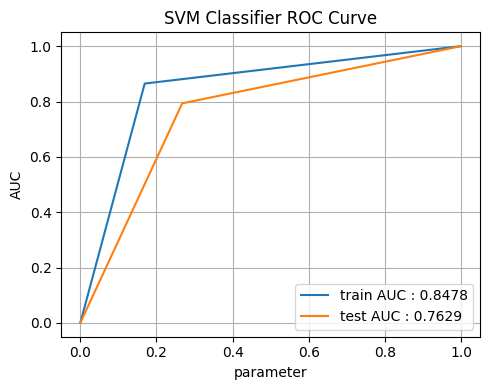

In [31]:
roc_results = get_roc_curve('SVM Classifier',
                             svm_model)

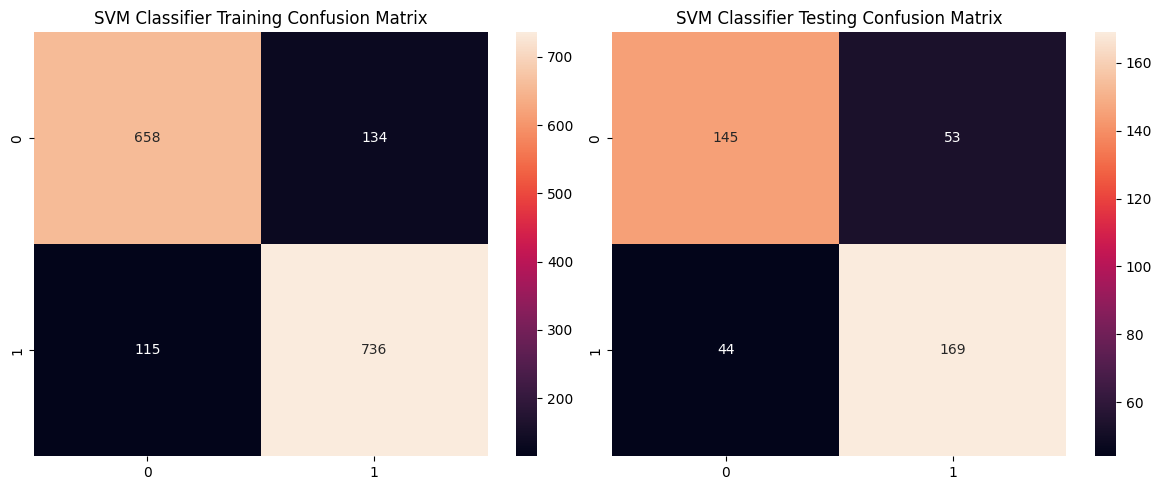

In [32]:
results = get_confusion_matrix('SVM Classifier',
                                roc_results)

In [33]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.7672    0.7323    0.7494       198
           1     0.7613    0.7934    0.7770       213

    accuracy                         0.7640       411
   macro avg     0.7642    0.7629    0.7632       411
weighted avg     0.7641    0.7640    0.7637       411

confusion matrix:  [0.73232323 0.79342723]
Accuracy: 0.7639902676399026
Recall:  0.7628752311850904
Precision:  0.7642285142285142
F1: 0.7631827497104161


### Binomial Naive Bayes 

In [34]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)
Ypredtest = bnb_model.predict_proba(X_test)[:,1]

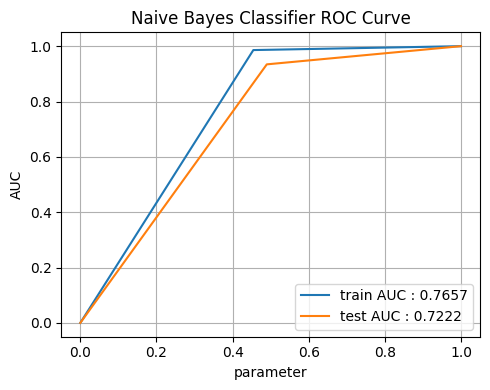

In [35]:
roc_results = get_roc_curve('Naive Bayes Classifier',
                             bnb_model)

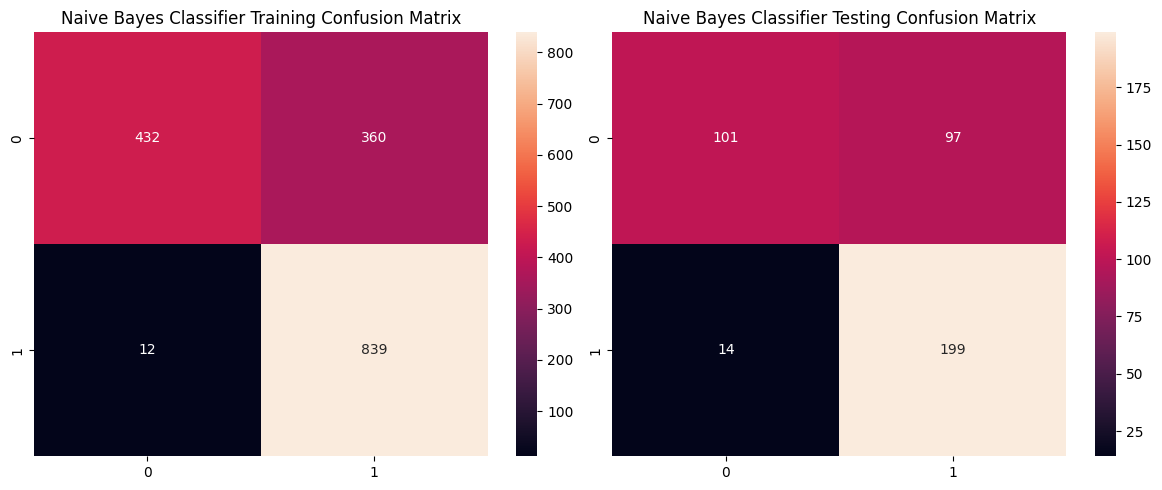

In [36]:
results = get_confusion_matrix('Naive Bayes Classifier',
                                roc_results)

In [37]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.8783    0.5101    0.6454       198
           1     0.6723    0.9343    0.7819       213

    accuracy                         0.7299       411
   macro avg     0.7753    0.7222    0.7136       411
weighted avg     0.7715    0.7299    0.7161       411

confusion matrix:  [0.51010101 0.9342723 ]
Accuracy: 0.7299270072992701
Recall:  0.7221866552852468
Precision:  0.7752790834312573
F1: 0.713646377975985


In [38]:
import tabulate
print('Task P2 : TF vector')
conclusion = [['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Train AUC', 'Test AUC', ],
              ['Logistic Regression', 84.1, 84.2, 84.3, 84.1, 0.99, 0.84],
              ['XGBoost Classifier', 91.2, 91.4, 91.1, 91.2, 1, 0.91],
              ['Random Forest Classifier', 89, 89.3, 88.8, 88.9, 0.98, 0.88],
              ['SVM Classifier', 76.3, 76.4, 76.4, 76.3, 0.84, 0.76],
              ['Naive Bayes Classifier',  72.9, 77.5, 72.2, 71.3, 0.76, 0.72],   
             ]
print(tabulate.tabulate(conclusion, tablefmt='fancy_grid'))

Task P2 : TF vectors - Model all-mpnet-base-v2
╒══════════════════════════╤══════════╤═══════════╤════════╤══════════╤═══════════╤══════════╕
│ Model                    │ Accuracy │ Precision │ Recall │ F1 Score │ Train AUC │ Test AUC │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ Logistic Regression      │ 84.1     │ 84.2      │ 84.3   │ 84.1     │ 0.99      │ 0.84     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ XGBoost Classifier       │ 91.2     │ 91.4      │ 91.1   │ 91.2     │ 1         │ 0.91     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ Random Forest Classifier │ 89       │ 89.3      │ 88.8   │ 88.9     │ 0.98      │ 0.88     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ SVM Classifier           │ 76.3     │ 76.4      │ 76.4   │ 76.3     │ 0.84      │ 0.76     │
├──